# **Image Noise Exploration**

In this notebook, we will explore image noise as modeled by this [paper](https://people.csail.mit.edu/billf/publications/Noise_Estimation_Single_Image.pdf)

Main Assumptions
- Image noise is generated by 2 noise processes
    - One that is dependent on scene irradiance
    - Another is independent of scene irradaiance
- Spatial Correlations are introduced via Bayer Filtering and Demosacing

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

Generate Test Image

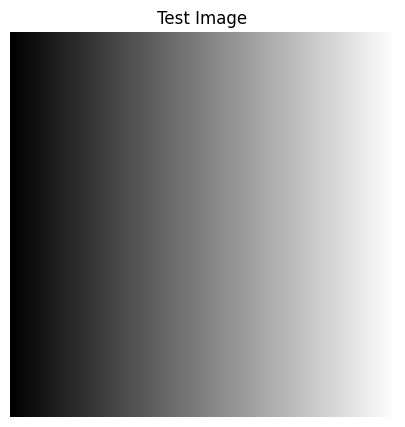

In [2]:
image = np.tile(np.linspace(0, 1, 256), reps=(256, 1))
image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(image, cmap="gray")
plt.title("Test Image")
plt.axis("off");

Get the noise and noisy images

In [25]:
from image_noise_model import *

camera_noise = get_camera_noise(image, s_sigma=0.01, c_sigma=0.02, c=3)
iid_image = add_iid_noise(image, s_sigma=0.01, c_sigma=0.02, c=3)


iid_noise = iid_image - image # get iid noise
noisy_image = image + camera_noise # add correlated noise to image


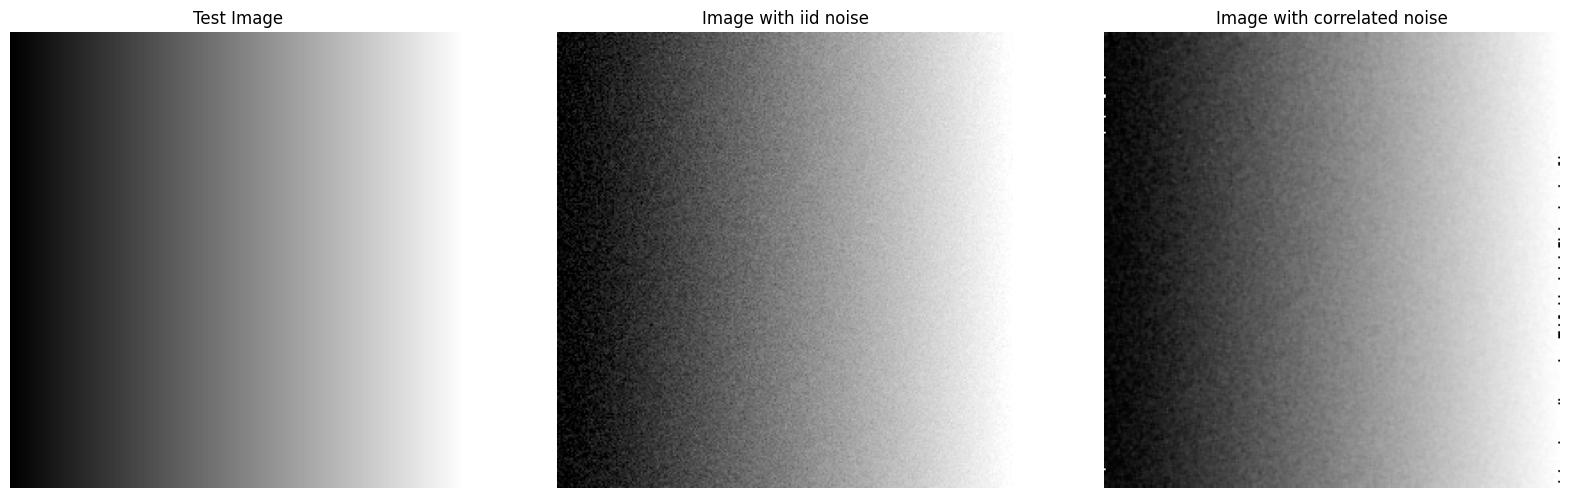

In [26]:
_, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(image, cmap="gray")
ax[0].axis(False)
ax[0].set_title("Test Image")

ax[1].imshow(iid_image, cmap="gray")
ax[1].axis(False)
ax[1].set_title("Image with iid noise")

ax[2].imshow(noisy_image, cmap="gray")
ax[2].axis(False)
ax[2].set_title("Image with correlated noise");

Let's see how correlated the nois sources are. We will need to pass in float images to ensure that we don't encounter any inconveineint roundoff errors.

In [82]:
iid_noise_norm = cv2.normalize(iid_noise, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
camera_noise_norm = cv2.normalize(camera_noise, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [83]:
iid_auto_corr = cv2.filter2D(iid_noise_norm, ddepth=-1, kernel=iid_noise_norm)
cam_auto_corr = cv2.filter2D(camera_noise_norm, ddepth=-1, kernel=camera_noise_norm)

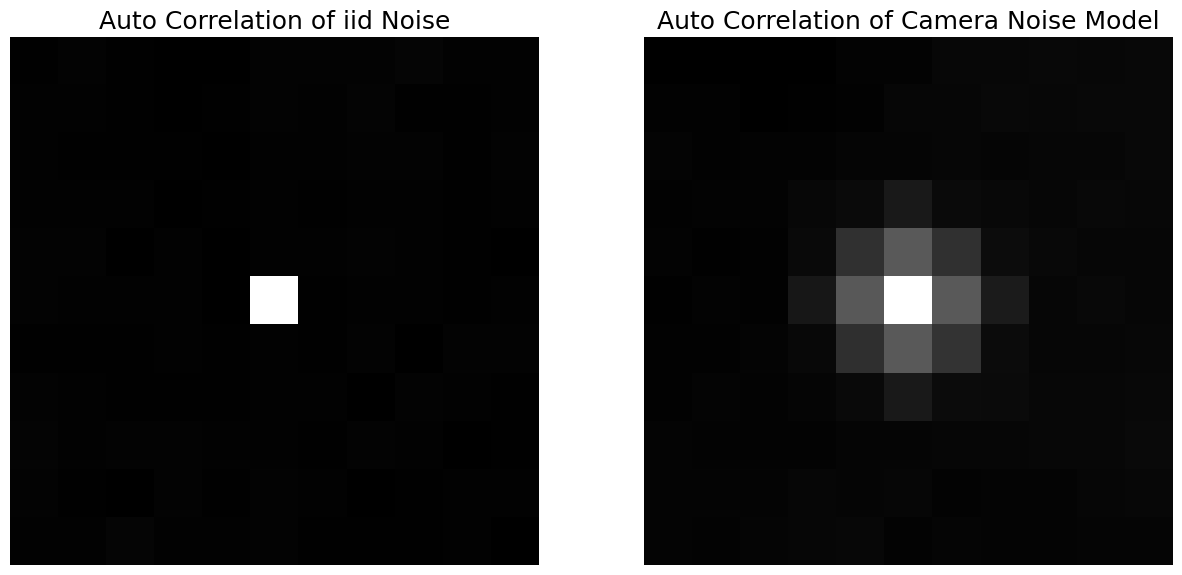

In [85]:
_, ax = plt.subplots(1, 2, figsize=(15,10))

ax[0].imshow(iid_auto_corr[123:134, 123:134], cmap="gray")
ax[0].axis(False)
ax[0].set_title("Auto Correlation of iid Noise", size=18)

ax[1].imshow(cam_auto_corr[123:134, 123:134], cmap="gray")
ax[1].axis(False)
ax[1].set_title("Auto Correlation of Camera Noise Model", size=18);

The main take away is that the image noise from our camera model is correlated. Generating this image noise is comutationally expensive, an easier way would be to just add correlated noise to the image. Let's see how to do that.

In [203]:
corr_noise = np.random.normal(0, 0.02, size=image.shape) * np.sqrt(image)*10
corr_noise += np.random.normal(0, 0.02, size=image.shape)

kernel = np.ones((3,3))/9
corr_noise = cv2.filter2D(corr_noise, ddepth=-1, kernel=kernel)

# normalize to 0-1 to compare to other noise sources
corr_noise_norm = cv2.normalize(corr_noise, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# get auto correlation of correlated noise
auto_corr_noise = cv2.filter2D(corr_noise_norm, ddepth=-1, kernel=corr_noise_norm)

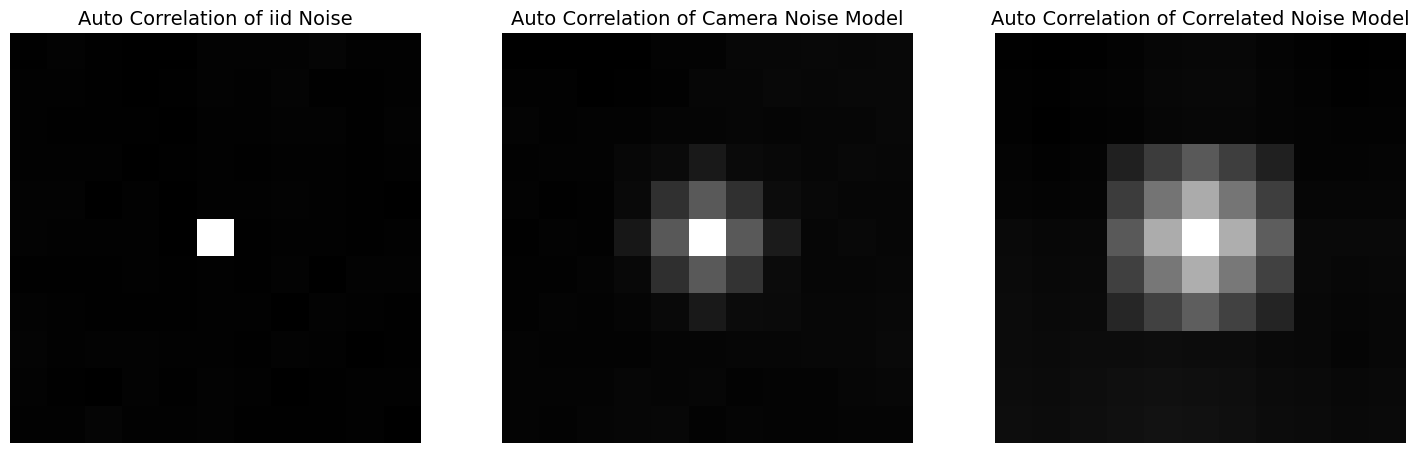

In [204]:
_, ax = plt.subplots(1, 3, figsize=(18,10))

ax[0].imshow(iid_auto_corr[123:134, 123:134], cmap="gray")
ax[0].axis(False)
ax[0].set_title("Auto Correlation of iid Noise", size=14)

ax[1].imshow(cam_auto_corr[123:134, 123:134], cmap="gray")
ax[1].axis(False)
ax[1].set_title("Auto Correlation of Camera Noise Model", size=14);

ax[2].imshow(auto_corr_noise[123:134, 123:134], cmap='gray')
ax[2].axis(False)
ax[2].set_title("Auto Correlation of Correlated Noise Model", size=14);

Now let's inspect the eigenvalues of the noise

In [205]:
# u1, v1 = np.linalg.eig(iid_noise_norm)

# u2, v2 = np.linalg.eig(camera_noise_norm)

u1, v1 = np.linalg.eig(iid_image)

u2, v2 = np.linalg.eig(noisy_image)

u3, v3 = np.linalg.eig(corr_noise_norm)

In [193]:
iid_noise_norm.mean()

0.47057265

Plot the eigenvalues

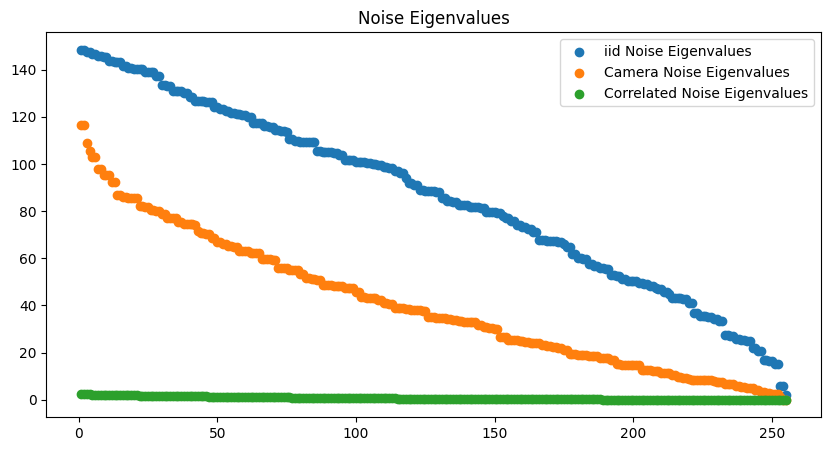

In [195]:
plt.scatter(np.arange(1, len(u1)), np.sort(np.abs(u1))[::-1][1:], label="iid Noise Eigenvalues")
plt.scatter(np.arange(1, len(u2)), np.sort(np.abs(u2))[::-1][1:], label="Camera Noise Eigenvalues")
# plt.scatter(np.arange(1, len(u3)), np.sort(np.abs(u3))[::-1][1:], label="Correlated Noise Eigenvalues")
plt.title("Noise Eigenvalues")
plt.legend();

Plot angles of the eigenvalues

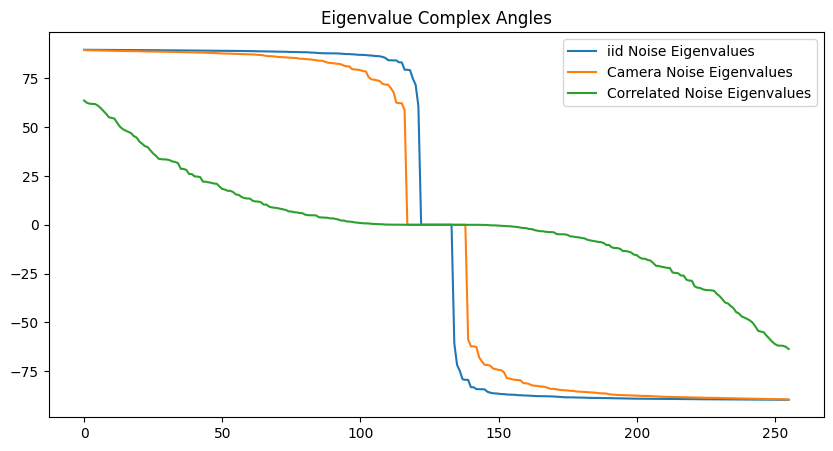

In [197]:
# sort complex eigenvalues
u1 = np.sort(u1)[::-1]
u2 = np.sort(u2)[::-1]
u3 = np.sort(u3)[::-1]

re_u1 = np.real(u1)
im_u1 = np.imag(u1)

re_u2 = np.real(u2)
im_u2 = np.imag(u2)

re_u3 = np.real(u3)
im_u3 = np.imag(u3)

angles_1 = np.arctan(im_u1, re_u1)*180/np.pi
angles_2 = np.arctan(im_u2, re_u2)*180/np.pi
angles_3 = np.arctan(im_u3, re_u3)*180/np.pi

plt.plot(angles_1, label="iid Noise Eigenvalues")
plt.plot(angles_2, label="Camera Noise Eigenvalues")
plt.plot(angles_3, label="Correlated Noise Eigenvalues")
plt.title("Eigenvalue Complex Angles")
plt.legend();

Display noise Power Spectral Densities PSDs. The PSD is Fourier Transform of the Autocorrelation.

In [198]:
iid_psd = np.abs(np.fft.fftshift(np.fft.fft2(iid_auto_corr)))
cam_psd = np.abs(np.fft.fftshift(np.fft.fft2(cam_auto_corr)))
cor_psd = np.abs(np.fft.fftshift(np.fft.fft2(auto_corr_noise)))

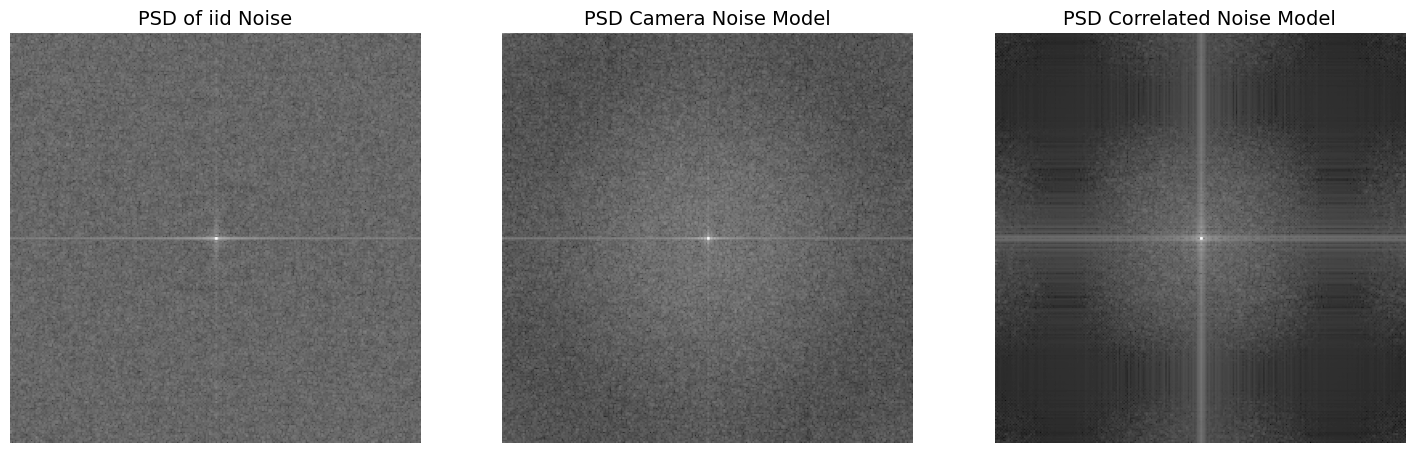

In [199]:
from matplotlib import colors


_, ax = plt.subplots(1, 3, figsize=(18,10))

ax[0].imshow(iid_psd, cmap="gray", norm=colors.LogNorm())
ax[0].axis(False)
ax[0].set_title("PSD of iid Noise", size=14)

ax[1].imshow(cam_psd, cmap="gray", norm=colors.LogNorm())
ax[1].axis(False)
ax[1].set_title("PSD Camera Noise Model", size=14);

ax[2].imshow(cor_psd, cmap='gray', norm=colors.LogNorm())
ax[2].axis(False)
ax[2].set_title("PSD Correlated Noise Model", size=14);

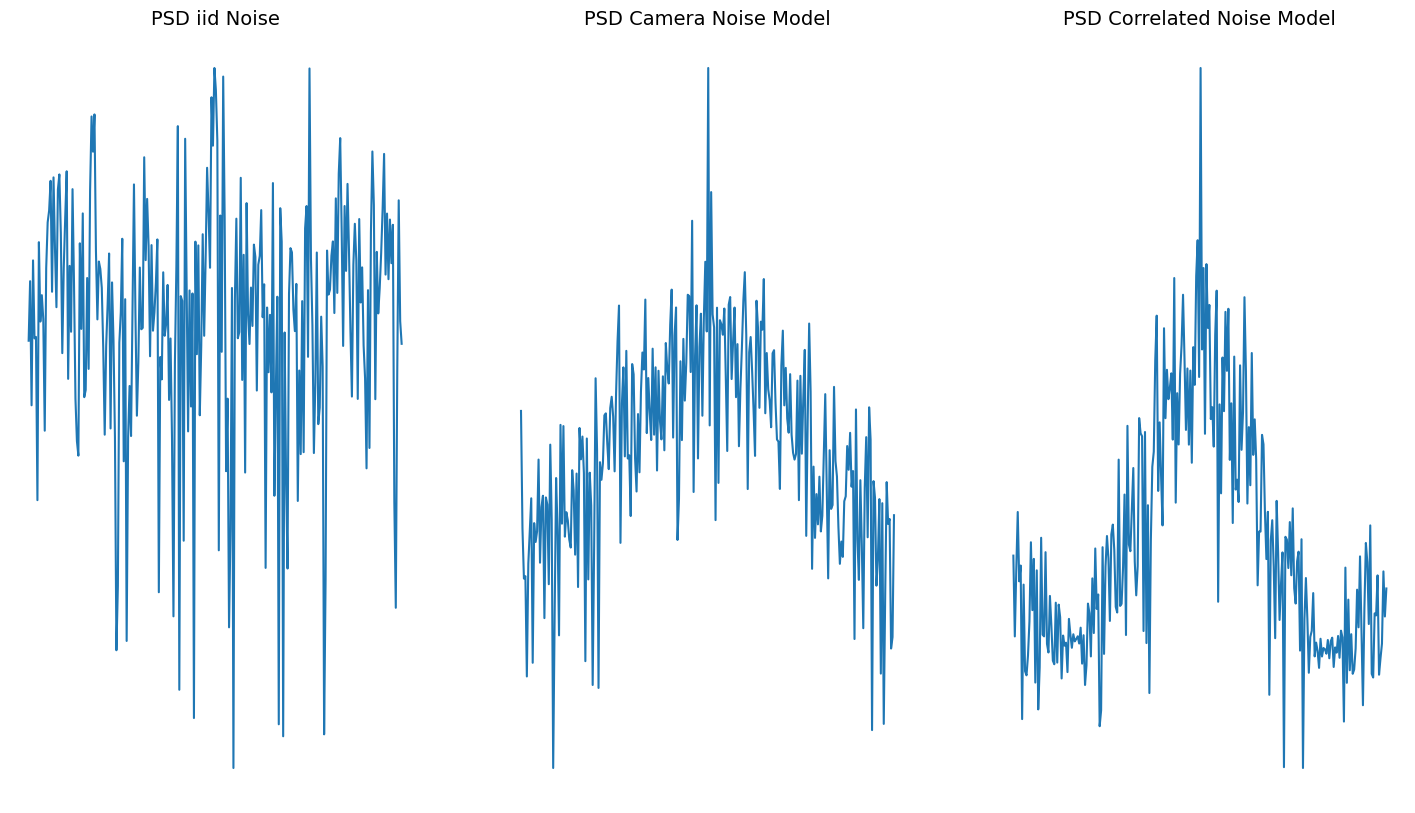

In [200]:
_, ax = plt.subplots(1, 3, figsize=(18,10))

ax[0].plot(np.log(iid_psd[125, :]))
ax[0].axis(False)
ax[0].set_title("PSD iid Noise", size=14)

ax[1].plot(np.log(cam_psd[125, :]))
ax[1].axis(False)
ax[1].set_title("PSD Camera Noise Model", size=14);

ax[2].plot(np.log(cor_psd[125, :]))
ax[2].axis(False)
ax[2].set_title("PSD Correlated Noise Model", size=14);